In [11]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from skimage import color
from skimage import filters
from skimage.morphology import disk
from openslide import OpenSlide, OpenSlideUnsupportedFormatError

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.sampler as sampler

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_utils import*

# Base Directory where data is stored

base_data_dir = '/media/rene/Data/CAMELYON16'
base_out_dir = '/media/rene/Data/camelyon_out'

nontumor_data_dir = '/media/rene/Data/CAMELYON16/TrainingData/Train_Normal'
tumor_data_dir = '/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor'

ModuleNotFoundError: No module named 'skimage'

In [2]:
wsi_path = '/media/rene/Data/CAMELYON16/TrainingData/Train_Normal/Normal_001.tif'
wsi = OpenSlide(wsi_path)
print(wsi.level_count)

10


In [3]:
print('wsi.level_dimensions', wsi.level_dimensions)
print('wsi.level_downsamples', wsi.level_downsamples)

wsi.level_dimensions ((97792, 221184), (49152, 110592), (24576, 55296), (12288, 27648), (6144, 13824), (3072, 7168), (1536, 3584), (1024, 2048), (512, 1024), (512, 512))
wsi.level_downsamples (1.0, 1.9947916666666665, 3.989583333333333, 7.979166666666666, 15.958333333333332, 31.345238095238095, 62.69047619047619, 101.75, 203.5, 311.5)


# Reproduce the preprocessing method for WSI
CLASSIFICATION AND DISEASE LOCALIZATION IN HISTOPATHOLOGY USING ONLY GLOBAL LABELS: A WEAKLY-SUPERVISED APPROACH

### High level image preprocessing
1. Read in the image at a low resolution and convert to hsv (what resolution did they use? only matters a little)
2. Do Otsu's method on hue and saturation (I just did saturation)
3. Color normalization:  Subtract min in R, G, B, channels independently and rescale to [0, 255] (should this be done independently for each tile, or at the downsampled full tile?)

### Helpful stuff:
https://github.com/Peter554/WSI_sampler/

<class 'PIL.Image.Image'>
(3584, 1536, 3)


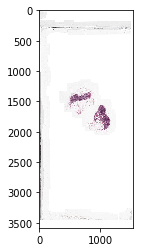

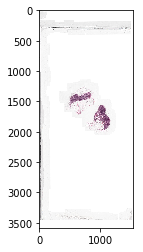

In [4]:
# read in the image at a low resolution (6) and convert to hsv
# is the 4 channel to 3-channel hsv conversion ok? Img looks resonable
img = wsi.read_region(location=(0, 0), level=6, size=wsi.level_dimensions[6]).convert('RGB')
plt.imshow(img)
print(type(img))
img = img.convert('HSV')
print(np.array(img).shape)
plt.figure()
plt.imshow(img)

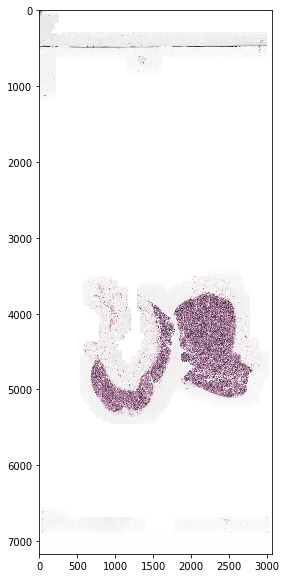

In [15]:
wsi_path = '/media/rene/Data/CAMELYON16/TrainingData/Train_Normal/Normal_009.tif'
wsi = OpenSlide(wsi_path)

img = wsi.read_region(location=(0, 0), level=5, size=wsi.level_dimensions[5]).convert('RGB')
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)
fig.savefig('/media/rene/Data/camelyon_out/figures/wsi_example.jpeg', bbox_inches='tight', pad_inches=0)

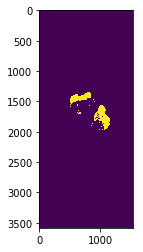

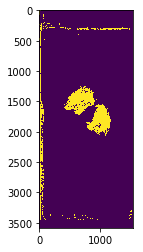

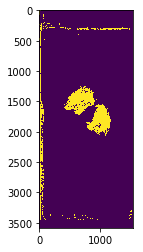

In [5]:
# do otsu's method on the saturation ??? paper does it on hue and saturation, how???
img_saturation = np.asarray(img)[:, :, 1]
threshold = filters.threshold_otsu(img_saturation)
high_saturation = (img_saturation > threshold)
# otsu's on the hue:
img_hue = np.asarray(img)[:, :, 0]
threshold = filters.threshold_otsu(img_hue)
high_hue = (img_hue > threshold)

mask = high_saturation | high_hue

plt.figure()
plt.imshow(high_saturation)
plt.figure()
plt.imshow(high_hue)
plt.figure()
plt.imshow(mask)

## Put it together

In [6]:
def generate_mask(wsi, mask_level=8, disk_radius=False):
    img = wsi.read_region(location=(0, 0), level=mask_level, size=wsi.level_dimensions[mask_level]).convert('HSV')
    img_saturation = np.asarray(img)[:, :, 1]
    threshold = filters.threshold_otsu(img_saturation)
    high_saturation = (img_saturation > threshold)
    
    # optionally use the disk method (sensible radius was 10)
    if disk_radius!=False:
        disk_object = disk(disk_radius)
        mask = closing(high_saturation, disk_object)
        mask = opening(mask, disk_object)
    else: 
        mask = high_saturation
    return mask

(2048, 1024)


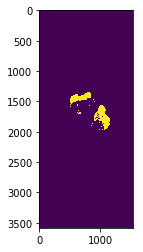

In [7]:
mask = generate_mask(wsi, mask_level=7)
print(mask.shape)
plt.imshow(high_saturation)

### Selecting tiles
* Sample randomly on a fixed grid 
* Number of samples per slide: min(total_tiles_in_slide, max(min_tiles_in_any_slide, .5*average tiles per slide)
* ? Only sample if fully inside the selected patch at the lower resolution (no 0 padding or letting the tile get outside the patch

In [49]:
def est_total_tiles(wsi, mask, mask_level):
    image_size = 224
    # NOT CORRECT WAY. Just estimate by comparing number of pixels in mask to size of img.
    # Should still give decent results though
    # a patch is the area of one pixel in the downsampled mask. Will be a square of length downsample factor
    num_patches = np.sum(mask)
    total_pixels = num_patches*wsi.level_downsamples[mask_level]**2
    total_tiles = total_pixels/image_size**2
    return total_tiles
    
def sample_tiles(wsi, wsi_name, mask, mask_level, out_dir, num_samples, tile_size=224):        
    patch_size = np.round(mask_level) # size of each pixel in mask in terms of level 0
    curr_samples = 0
    locations = []
    while(curr_samples < num_samples):
        # randomly select a pixel in the mask to sample from
        all_indices = np.asarray(np.where(mask))
        idx = np.random.randint(0, len(all_indices[0]))
        sample_patch_ind = np.array([all_indices[1][idx], all_indices[0][idx]]) # not sure why this is backwards like that
        locations.append(sample_patch_ind)
        # convert to coordinates of level 0
        sample_patch_ind = np.round(sample_patch_ind*wsi.level_downsamples[mask_level])
        # random point inside this patch for center of new image (sampled image could extend outside patch or mask)
        # sample_index should be top left corner
        location = (np.random.randint(sample_patch_ind[0]-tile_size/2, sample_patch_ind[0]+tile_size/2),
                    np.random.randint(sample_patch_ind[1]-tile_size/2, sample_patch_ind[1]+tile_size/2))
        
        try:
            img = wsi.read_region(location=location, level=0, size=(tile_size, tile_size))
        except:
            continue # if exception try sampling a new location. Hopefully was was out of bounds
        curr_samples+=1
        
        img = img-np.amin(img) # left shift to 0
        img = (img/np.amax(img))*255 # scale to [0, 255]
        img = Image.fromarray(img.astype('uint8'))  

        out_file = os.path.join(out_dir, wsi_name +'_'+ str(curr_samples))

        img.save(out_file, 'PNG')
        plt.figure()
        plt.imshow(img)
    return locations


7395.325566398568


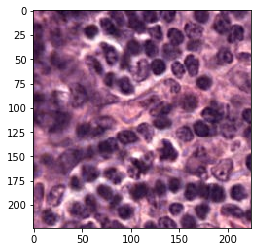

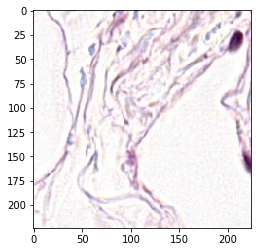

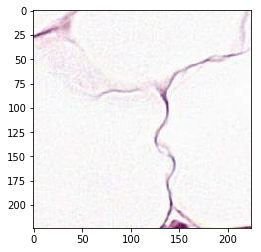

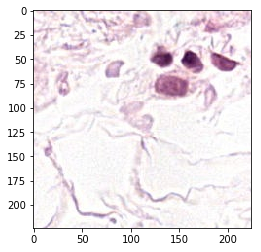

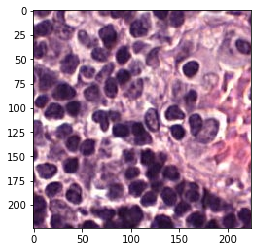

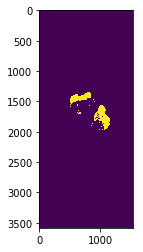

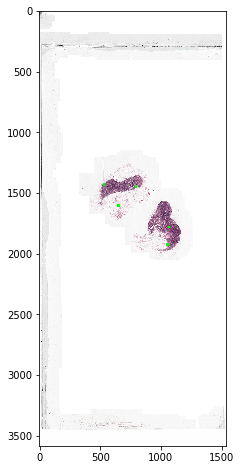

In [50]:
wsi_path = '/media/rene/Data/CAMELYON16/TrainingData/Train_Normal/Normal_001.tif'
wsi = OpenSlide(wsi_path)
wsi_name = 'Normal_001'
mask_level = 6
out_dir = '/media/rene/Data/camelyon_out/test'
num_samples = 5
 
mask = generate_mask(wsi, mask_level)
total_samples = est_total_tiles(wsi, mask, mask_level)
print(total_samples)
locations = sample_tiles(wsi, wsi_name, mask, mask_level, out_dir, num_samples, tile_size=224)

img = np.asarray(wsi.read_region(location=(0, 0), level=6, size=wsi.level_dimensions[6]).convert('RGB'))
plt.figure()
plt.imshow(mask)

# set the locations to a value
img.setflags(write=1)
for location in locations:
    img[location[1]-10:location[1]+10, location[0]-10:location[0]+10, :] = [0, 255, 0]
#     img[location[0], location[1],:] = [0, 255, 0]
        
plt.figure(figsize=(8, 8))
plt.imshow(img)

## Annotations
* Annotations are NOT ground truth
* Annotations have multiple classes, and include more area than the ground truth. They include some non-tumor regions.

(6912, 3056)


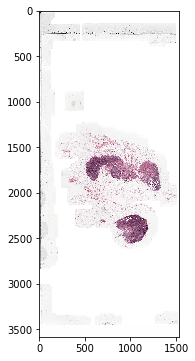

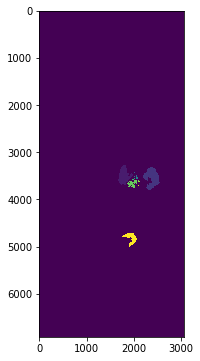

In [30]:
number = '011'
wsi = OpenSlide('/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_'+number+'.tif')
img = wsi.read_region(location=(0, 0), level=6, size=wsi.level_dimensions[6]).convert('RGB')
plt.figure(figsize=(6, 6))
plt.imshow(img)

img = Image.open('/media/rene/Data/CAMELYON16/EvaluationMasks/Tumor_'+number+'_EvaluationMask.png')
mask = np.asarray(img)
print(mask.shape)
plt.figure(figsize=(6, 6))
plt.imshow(mask)

In [33]:
unique, counts = np.unique(mask, return_counts=True)
print(np.asarray((unique, counts)).T)

[[       0 20885099]
 [       1    73411]
 [       2    99272]
 [       3      203]
 [       4      425]
 [       5     1562]
 [       6     1514]
 [       7      202]
 [       8      290]
 [       9      619]
 [      10    21119]
 [      11      525]
 [      12      690]
 [      13    38141]]


## Ground Truth
* Binary mask in almost the same format as the slides.

10
wsi.level_dimensions ((97792, 221184), (49152, 110592), (24576, 55296), (12288, 27648), (6144, 13824), (3072, 7168), (1536, 3584), (1024, 2048), (512, 1024), (512, 512))
wsi.level_downsamples (1.0, 1.9947916666666665, 3.989583333333333, 7.979166666666666, 15.958333333333332, 31.345238095238095, 62.69047619047619, 101.75, 203.5, 311.5)
8
wsi.level_dimensions ((97792, 221184), (48896, 110592), (24448, 55296), (12224, 27648), (6112, 13824), (3056, 6912), (1528, 3456), (764, 1728))
wsi.level_downsamples (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)


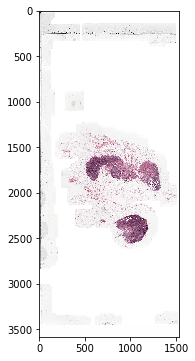

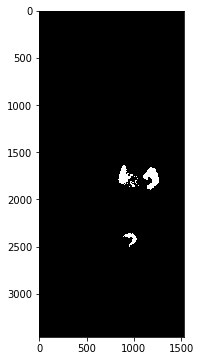

In [41]:
number = '011'
wsi = OpenSlide('/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_'+number+'.tif')
img = wsi.read_region(location=(0, 0), level=6, size=wsi.level_dimensions[6]).convert('RGB')
plt.figure(figsize=(6, 6))
plt.imshow(img)
print(wsi.level_count)
print('wsi.level_dimensions', wsi.level_dimensions)
print('wsi.level_downsamples', wsi.level_downsamples)

wsi = OpenSlide('/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_'+number+'_Mask.tif')
img = wsi.read_region(location=(0, 0), level=6, size=wsi.level_dimensions[6]).convert('RGB')
plt.figure(figsize=(6, 6))
plt.imshow(img)
print(wsi.level_count)
print('wsi.level_dimensions', wsi.level_dimensions)
print('wsi.level_downsamples', wsi.level_downsamples)

In [19]:
wsi_path = '/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_'+number+'.tif'

annotation_path = '/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_'+number+'_Mask.tif'

base_dir = wsi_path.rsplit('TrainingData', 1)[:-1][0]
annotation_file_name = wsi_path.rsplit('/', 1)[-1].replace(".tif", "_Mask.tif")
annotation_path = os.path.join(base_dir, 'TrainingData', 'Ground_Truth', 'Mask', annotation_file_name)
print(annotation_path)

/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_011_Mask.tif


In [60]:
tumor_mask_level = 5
tile_size=224
tile_sample_level=0

tumor_annotation_wsi = OpenSlide('/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_001_Mask.tif')
tumor_mask = tumor_annotation_wsi.read_region(location=(0, 0), level=tumor_mask_level, 
    size=tumor_annotation_wsi.level_dimensions[tumor_mask_level]).convert('RGB')

unique, counts = np.unique(tumor_mask, return_counts=True)
print(np.asarray((unique, counts)).T)

[[       0 63335865]
 [     255    33351]]


In [107]:
wsi = WSI('/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_011.tif')
out_dir = '/media/rene/Data/camelyon_out/test/normal'
num_tiles = 11
tile_class = 'tumor'

wsi.sample_from_tumor_region(out_dir, num_tiles, tile_size=224, tile_sample_level=0)

len(all_indices) 3
(58784, 113223)
(58009, 106467)
(55516, 112101)
(55951, 114005)
(58375, 113959)
(60213, 153777)
(55287, 111793)
(59406, 111705)
(59646, 112231)
(74332, 112688)
(77901, 110096)


In [108]:
wsi = WSI('/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_011.tif')
out_dir = '/media/rene/Data/camelyon_out/test/normal'
num_tiles = 11
tile_class = 'tumor'

wsi.sample_from_normal_region(out_dir, num_tiles, tile_size=224, tile_sample_level=0)

(60513, 154339)
(45653, 111441)
(18597, 92013)
(21054, 112036)
(33904, 106353)
(53033, 106241)
(61650, 127358)
(31334, 131030)
(35871, 123671)
(38121, 138171)
(73320, 101040)


(224, 224, 3)


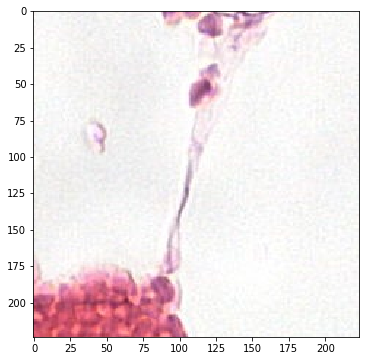

In [117]:
image_loc = '/media/rene/Data/camelyon_out/test/normal/Tumor_011_normal_4'

img=np.asarray(Image.open(image_loc))
print(img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(img)

In [120]:
num_tiles = 11
out_dir = '/media/rene/Data/camelyon_out/test'

wsi = WSI('/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_011.tif')
wsi.make_tiles_by_class(out_dir, num_tiles, tile_class='normal', tile_size=224, tile_sample_level=0)
wsi.make_tiles_by_class(out_dir, num_tiles, tile_class='tumor', tile_size=224, tile_sample_level=0)

wsi = WSI('/media/rene/Data/CAMELYON16/TrainingData/Train_Normal/Normal_001.tif')
wsi.make_tiles_by_class(out_dir, num_tiles, tile_class='normal', tile_size=224, tile_sample_level=0)
wsi.make_tiles_by_class(out_dir, num_tiles, tile_class='tumor', tile_size=224, tile_sample_level=0)

(52432, 118835)
(70063, 106029)
(57999, 117385)
(38858, 88898)
(20585, 107548)
(68645, 106593)
(39509, 122472)
(80929, 107821)
(60879, 110013)
(42619, 100067)
(31372, 89147)
len(all_indices) 3
(55832, 109830)
(57156, 115975)
(71765, 111755)
(56141, 116377)
(62366, 156955)
(57383, 152258)
(60216, 154069)
(64849, 115562)
(54417, 110033)
(56623, 108719)
(59150, 153101)
This is normal WSI, can't sample tumor from it


# Should check that sampling is somewhat uniform in the region we want!

# Train - Test split

In [14]:
SEED = 101
np.random.seed(SEED)

data_loc = '/media/rene/Data/CAMELYON16'
out_file = '/media/rene/Data/camelyon/other/ttv_split.p'
valid_frac = .2

# args.data_loc is location of CAMELYON16 directory
normal_loc = os.path.join(data_loc, 'TrainingData', 'Train_Normal')
tumor_loc = os.path.join(data_loc, 'TrainingData', 'Train_Tumor')
num_normal = len(glob.glob(os.path.join(normal_loc, '*')))
num_tumor = len(glob.glob(os.path.join(tumor_loc, '*')))
num_all = num_normal+num_tumor

# create validation set. Randomly sample args.valid_frac of tumor and non-tumor training set
normal_wsi_locs = glob.glob(os.path.join(normal_loc, '*'))
normal_vaild_idx = np.random.choice(num_normal, int(np.round(num_normal*valid_frac)))
tumor_wsi_locs = glob.glob(os.path.join(tumor_loc, '*'))
tumor_vaild_idx = np.random.choice(num_tumor, int(np.round(num_tumor*valid_frac)))

ttv_split = {}
ttv_split['normal_vaild_idx'] = normal_vaild_idx
ttv_split['tumor_vaild_idx'] = tumor_vaild_idx

pickle.dump( ttv_split, open( out_file, "wb" ) )

In [15]:
split = pickle.load( open( out_file, "rb" ) )
print(split)

{'normal_vaild_idx': array([ 95,  11,  81,  70,  63,  87,  75, 137,  40, 132,  63,  60, 110,
         5, 140,  40,  49,  83, 111, 136, 115, 157, 115,  59,  44,  72,
        19, 126, 138,  76, 107,  87]), 'tumor_vaild_idx': array([  0, 105,  73,   8,  62,  36,  83,  99,  28,  63,   7,  10,  52,
        56, 103,  38,  73,  52,  18,  71, 103,  15])}


8


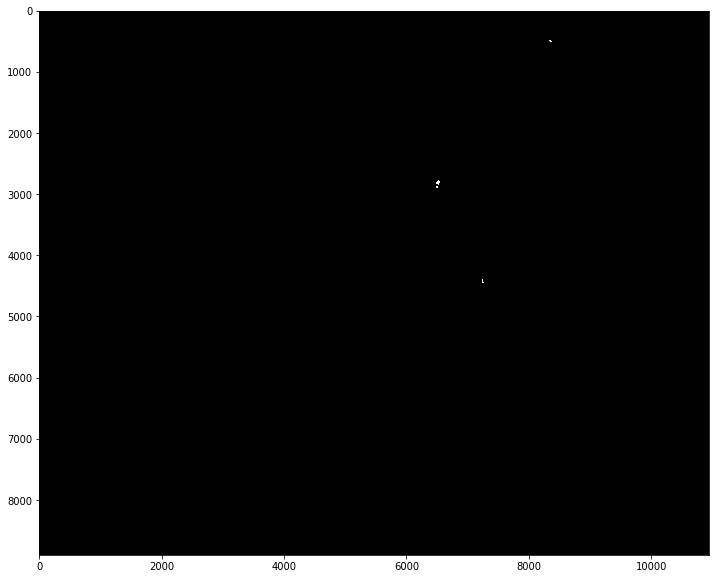

In [3]:
wsi_path = '/media/rene/Data/CAMELYON16/Testset/Ground_Truth/Masks/Test_116_Mask.tif'
wsi = OpenSlide(wsi_path)
print(wsi.level_count)

img = wsi.read_region(location=(0, 0), level=3, size=wsi.level_dimensions[3]).convert('RGB')
plt.figure(figsize=(12, 12))
plt.imshow(img)

## Look at some Patches

In [13]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/rene/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


<Figure size 432x288 with 0 Axes>

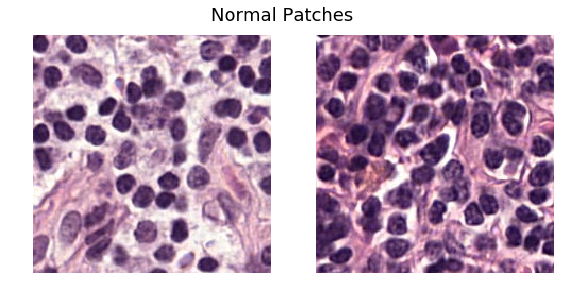

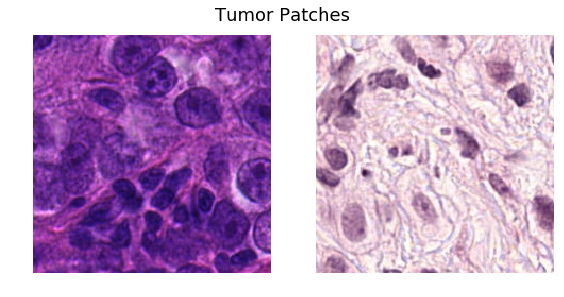

In [72]:
def display_from_class(PATH, num_per_class, num_row=1, names = False):
    """folder in keras format"""
    fig = plt.figure()
    img_classes = glob.glob(PATH+'/*')
    for class_ind, img_class in enumerate(img_classes):
        imgs = glob.glob(img_class+'/*')
        img_locs = random.sample(imgs, num_per_class)
        fig = plt.figure(figsize=(8, 8))
        for ind, img_loc in enumerate(img_locs):
            img=np.asarray(Image.open(img_loc))
            ax2 = fig.add_subplot(num_row, int(num_per_class/num_row), ind+1)
            plt.imshow(img)
            plt.axis('off')

        title = img_class.rsplit('/')[-1]
        if names :
            title = names[class_ind]
        plt.suptitle(title, fontsize=18)
        plt.axis('off')
        plt.tight_layout(rect=[0, .5, 1, 0.95])
        plt.show()

display_from_class('/home/rene/data/tiles_224_100t/sample/train/', 2, 1, ['Normal Patches', 'Tumor Patches'])

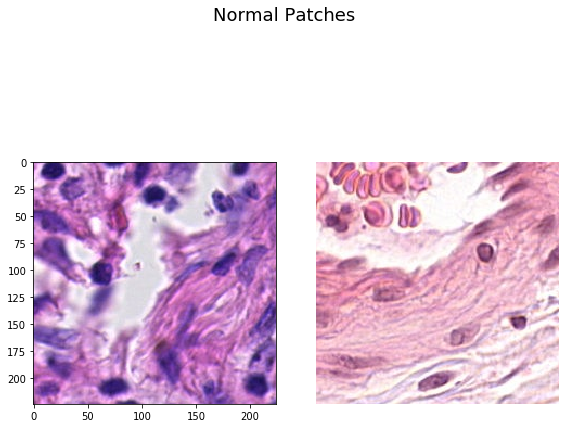

In [57]:
imgs = glob.glob('/home/rene/data/tiles_224_100t/sample/train/normal/*')
img_locs = random.sample(imgs, 2)
fig = plt.figure(figsize=(8, 8))
for ind, img_loc in enumerate(img_locs):
    img=np.asarray(Image.open(img_loc))
    ax2 = fig.add_subplot(1, 2, ind+1)
    plt.imshow(img)
    
plt.suptitle('Normal Patches', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

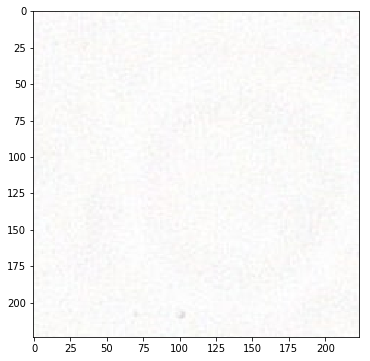

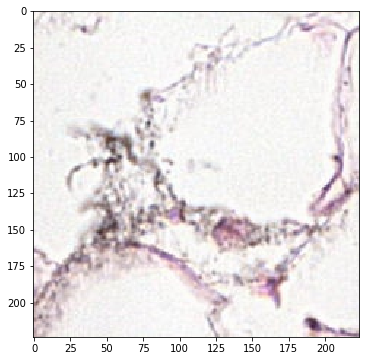

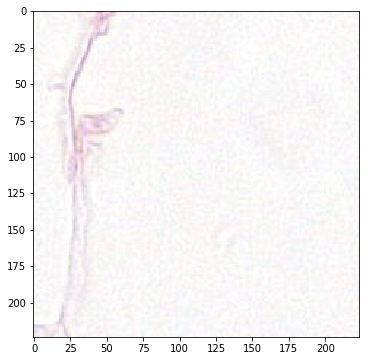

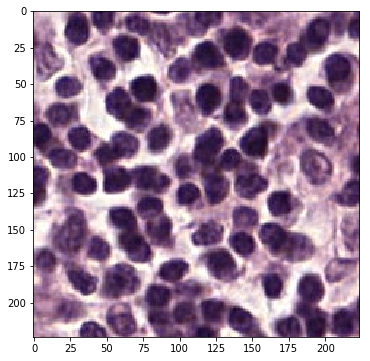

In [17]:
imgs = glob.glob('/home/rene/data/tiles_224_100t/sample/train/tumor/*')
img_locs = random.sample(imgs, 4)
fig = plt.figure(figsize=(8, 8))
for ind, img_loc in enumerate(img_locs):
    img=np.asarray(Image.open(img_loc))
    ax2 = fig.add_subplot(2, 2, ind+1)
    plt.imshow(img)
    
plt.suptitle('Normal Patches', fontsize=18)
plt.axis('off')
# plt.tight_layout()
plt.show()